# Mesures de similarité dans un graphe d'intéractions protéiques
## Historique


* 2013 : Tomas Mikolov et al. publient une série de papiers [1] sur l'apprentissage de représentations vectorielles pour les mots du language naturel. Un réseaux de neurone est entraîné à prédire, pour chaque mot $w$ d'un corpus, les mots-contexte $c$ environnants. Les poids du réseaux sont utilisés comme représentations vectorielles des mots $w$. Ces vecteurs permettent de réaliser des analogies sémantiques linéairement composables.
* 2014 : La méthode d'apprentissage par contraste au bruit (NCE, Noise-Contrastive Estimation) du modèle précédent est démontrée [2] equivalente à une factorization implicite d'une matrice mots-contextes, suite à la publication d'une méthode qui utilise une factorisation explicite (GloVe, [3]). La matrice factorisée est la matrice Ponctuelle d'Information Mutuelle, PMI (plus exactement, positive et décalée, Shifted Positive PMI, SPPMI) : 
$$ PMI(w,c) = \log \frac{p(w,c)}{p(w)p(c)} $$
$$ SPPMI(w,c) = \max \left( PMI(w,c) - \log \frac{\lambda}{N} , 0 \right) $$ où $\lambda$ désigne le nombre d'échantillions aléatoires contrastifs dans la méthode NCE équivalente.
* 2014 : Bryan Perozz et al. adaptent ces techniques à l'apprentissage de représentations associés aux sommets de graphes. La méthode *DeepWalk*[4] consiste a échantilloner uniformément des marches aléatoires dans le graphe, pour ensuite entraîner un réseaux de neurone avec ces séquences linéaires. L'espace des représentations capture les similarités de voisinage et d'appartenance aux groupes sociaux.
* 2015 : Shaosheng Cao et al.[5] proposent une version plus formalisée de *DeepWalk*[4], qui factorise explicitement des matrices SPPMI calculées à partir de la matrice d'adjacence du graphe et de ses puissances successives. Contrairement à DeepWalk, les relations à $k$-étapes sont capturées dans des sous-espaces indépendants, ce qui en fait une méthode réellement multi-échelle.

C'est cette dernière méthode, connue sous le doux nom de *GraRep*, qui est utilisée ici. Elle est lourde en calculs car elle nécessite d'instancier une matrice de probabilités de transitions à $k$-étapes, souvent dense. Cependant son comportement hors-ligne est plus simple à analyser avec les outils d'algèbre linéaire classiques. Avec moins de 10000 sommets, le calcul reste réaliseable sur une machine de bureau. *Walklets*[6] est une alternative plus légère, basée sur des échantillonages en ligne.


[1] [Distributed Representations of Words and Phrases and their Compositionality, Tomas Mikolov et al](https://arxiv.org/pdf/1310.4546.pdf)  
[2] [Neural Word Embedding as Implicit Matrix Factorization, Jeffrey Pennington et al](https://levyomer.files.wordpress.com/2014/09/neural-word-embeddings-as-implicit-matrix-factorization.pdf)  
[3] [GloVe: Global Vectors for Word Representation, Omer Levy et al](http://nlp.stanford.edu/pubs/glove.pdf)  
[4] [DeepWalk: Online Learning of Social Representations](http://perozzi.net/publications/14_kdd_deepwalk.pdf)  
[5] [GraRep: Learning Graph Representations with Global Structural Information (PayWall)](http://dl.acm.org/citation.cfm?id=2806512)  
[6] [Walklets: Multiscale Graph Embeddings for Interpretable Network Classification](https://arxiv.org/pdf/1605.02115.pdf)

In [3]:
import lzma
import numpy as np
import pandas as pd
from scipy import linalg

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition.pca import PCA

from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
graph = """
a b
a c
c d
d e
b e
e a
a d
"""
graph = [l.split(' ') for l in graph.split('\n') if l]
sommets = set(inter[0] for inter in graph) | set(inter[1] for inter in graph)

In [35]:
sommet2idx = {sommet : i for i, sommet in enumerate(sorted(sommets))}

A = np.zeros((len(sommets),)*2)
for i,j in graph:
    i = sommet2idx[i]
    j = sommet2idx[j]
    A[i,j] = 1
    A[j,i] = 1
A

array([[ 0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  0.]])

## Chargement du réseau

Le réseau d'intéraction protéine-protéine de S. cerevisiae est chargé sous la forme d'une matrice d'adjacence exporté depuis le logiciel cytoscape.

In [7]:
A = pd.read_csv(lzma.open('net.adj.xz', 'rb'), sep='\t', index_col=0).iloc[:,:-1]
names = A.columns

La matrice contient des -1 pour les liens inversés. On interprete ici le graphe comme étant non orienté. Ainsi les -1 sont changés en 1.

On s'assure que la matrice est bien symétrique (égale à sa transposée).

In [26]:
A = np.abs(A.as_matrix()).astype(bool)
assert (A == A.T).all()

AttributeError: 'numpy.ndarray' object has no attribute 'as_matrix'

La somme de chaque ligne de la matrice nous donne le degré de la protéine associée :

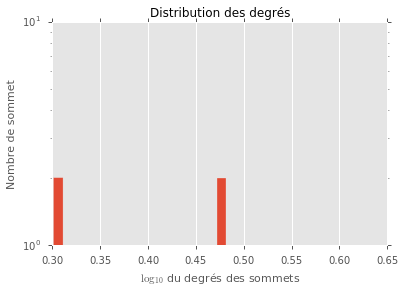

In [28]:
degrees = A.sum(axis=1)
plt.hist(np.log10(degrees), 30, log=True);
plt.xlabel('$\log_{10}$ du degrés des sommets')
plt.ylabel('Nombre de sommet')
plt.title('Distribution des degrés');

### Matrice de transitions
En divisant chaque ligne par le degrés du sommet associé, on obtient une matrice de probabilité de transition : l'entrée $T[i,j]$ est la probabilité de passer de la protéine $i$ à la protéine $j$ en choisisant une arrête partant de $i$ au hasard parmis les $degrees[i]$ choix possibles.

In [32]:
T = A.astype(float) / degrees[:,None]
T

array([[ 0.        ,  0.25      ,  0.25      ,  0.25      ,  0.25      ],
       [ 0.5       ,  0.        ,  0.        ,  0.        ,  0.5       ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.33333333,  0.        ,  0.33333333,  0.        ,  0.33333333],
       [ 0.33333333,  0.33333333,  0.        ,  0.33333333,  0.        ]])

### Marches aléatoires
Sachant que l'on part de la protéine $i$, la probabilité d'arriver à la protéine $j$ en passant par la protéine $k$ (suivant le chemin $i \rightarrow k \rightarrow j$) est $T[i,k] \times T[k,j]$.

Ainsi, la probabilité de passer de la protéine $i$ à $j$ avec deux transitions, en passant par tous les $k$ possibles est donnée par la somme :
$$ T^2[i,j] = \sum_k T[i,k]T[k,j] $$

On remarque que cela correspond au produit matriciel de la matrice $T$ avec elle même :
$T^2 = T \cdot T$. De manière identique, les probabilités de transitions à $n$ étapes sont données par $T^n$.

Lorsque le nombre de transition tend vers l'infini, les probabilité des positions d'arivés tendent vers un équilibre. En fonction de la taille et de la topologie du réseau, seulles les premières transitions vont nous intéresser.

In [40]:
T.dot(T)
T/T.sum(axis=0)

array([[ 0.        ,  0.42857143,  0.42857143,  0.23076923,  0.23076923],
       [ 0.3       ,  0.        ,  0.        ,  0.        ,  0.46153846],
       [ 0.3       ,  0.        ,  0.        ,  0.46153846,  0.        ],
       [ 0.2       ,  0.        ,  0.57142857,  0.        ,  0.30769231],
       [ 0.2       ,  0.57142857,  0.        ,  0.30769231,  0.        ]])

Jusqu'à maintenant on s'est intéresé à la probabilité d'arriver à une protéine $j$ pour un point de départ $i$ donné : $T^n[i,j]$ est la probabilité d'arriver en $n$-étapes à $j$ _sachant_ que l'on part de $i$ : 
$$T^n[i,j] = p^n(j\,|\,i) = \frac {p^n(i,j)}{p(i)} $$

On considère maintenant les chemins à $n$ étapes obtenues par l'experience aléatoire suivante : on choisit une protéine $i$ de départ de façon uniforme ($p(i)=1/N$). Ensuite on se déplace en choisisant $k_1$ parmis les $degree[i]$ partenaires de $i$ possibles, puis $k_2$ partenaire de $k_1$, etc ; jusqu'à arriver a $j$ après $n$ transitions :
$$ i \rightarrow k_1 \rightarrow k_2 \rightarrow \ldots \rightarrow j $$

Parmis toutes les marches aléatoires de $n$ étapes possibles, la probabilité de produire une marche partant de $i$ et arrivant à $j$ est noté $p^n(i,j)$. Avec les définitions précédentes de $T^n$ et $p(i)$, on obtient : 
$$ p^n(i,j) = p^n(j\,|\,i) \, p(i) = p^n(j\,|\,i) \frac{1}{N} = \frac{T^n[i,j]}{N} $$

La probabilité d'observer une marche qui se termine en $j$ est :
$$ p^n(j) = \sum_i p^n(j\,|\,i) \, p(i) = \frac{1}{N} \sum_i p^n(j\,|\,i) =  \frac{1}{N} \sum_i T^n[i,j] $$

Pour de longues marches aléatoires dans des réseaux densément connectés, le point d'arrivé ne dépend presque plus du point de départ. Suposons que ce soit entièrement le cas. Une marche est alors déterminée par le choix de la protéine $j$ d'arrivée, indépendant du choix de la protéine de départ $i$ : $\tilde{p^n}(i,j) = p(i) \, p^n(j)$.

Comparer notre réseaux a un réseaux densément connecté de façon uniforme (sans hubs, ni d'organisation *scale-free*) est utile en biologie. Une façon de procéder est de comparer les distributions des marches aléatoires qu'il génèrent. Cela est réalisé avec la divergence entre la distribution $p^n(i,j)$ du réseau réel et la distribution $\tilde{p^n}(i,j) = p(i) \, p^n(j)$ : 
$$ PMI(i,j) = \log_2 \frac{p^n(i,j)}{p(i) \, p^n(j)} = \log_2 \frac{p^n(j\,|\,i)}{p^n(j)} = \log_2 \frac {N \, T^n[i,j]}{\sum_i T^n[i,j]} $$

Cette mesure locale, associée à chaque couple $(i,j)$, est appelé *Pointwise Mutual Information*. Une $PMI(i,j) > 0$ signifie qu'il est plus fréquent d'observer une marche aléatoire entre $i$ et $j$ que ne laissent penser les probabilités marginales de partir de $i$ et d'arriver en $j$.


### Apparté : théorie de l'information

L'ésperance de la PMI (la moyenne des valeurs possibles pondérée par leur probabilités) est une mesure globale appelée information mutuelle (MI) : 
$$ MI(I,J) = \mathbb{E}[ PMI(i,j) ] = \sum_i \sum_j p^n(i,j) \log_2 \frac{p^n(i,j)}{p(i) \, p^n(j)} $$

Suposons que Bob souhaite transmettre à Alice la paire $(i,j)$ d'une marche aléatoire à $n$ étapes. Alice a aussi connaisance du réseaux et, par conséquence, de la loi de probabilité qui régie le couple de variables aléatoire $(I,J)$.

Une méthode consiste a envoyer $i$, puis $j$. La théorie de l'information permet de calculer le nombre minimal de bits que Bob doit transmetre à Alice pour envoyer $i$, l'entropie (ou l'incertitude) associé à la variable aléatoire $I$ : 
$$H(I) = - \sum_i p(i) \, log_2 p(i) = log_2 N$$
Puis, pour envoyer $j$, Bob doit envoyer $H(J) = - \sum_j p^n(j) log_2 p^n(j)$ bits.



Supposons que Bob ai déjà transmi le point de départ $i$. Si le point d'arrivé dépend fortement du point de départ, Alice peut déjà avoir une idée plus précise du point d'arrivé $j$ que Bob s'apprete a lui transmettre. Ainsi, plutot que d'envoyer au total $H(I) + H(J)$ bits, l'échange du couple $(i,j)$ peut se faire avec seulement $H(I,J)$ bits. $H(I,J)$ est appelé entropie jointe et prend en compte la dépendence entre les deux variables aléatoires $I$ et $J$:
$$ H(I,J) = - \sum_i \sum_j p^n(i,j) \log_2 p^n(i,j) $$

L'économie effectué en envoyant $i$, puis juste assez d'information pour deviner $j$ à partir de $i$, est appelé information mutuelle (MI) : 

$$MI(I,J) = H(I) + H(J) - H(I,J) = \sum_i \sum_j p^n(i,j) \log_2 \frac{p^n(i,j)}{p(i) \, p^n(j)} $$

L'information mutuelle est une mesure globale de la dépendance entre le point d'arrivé et le point de départ sur l'ensemble des marches aléatoires du réseau (toujours avec un nombre fixé de transitions). Si le réseaux est uniforme et dense, l'information mutuelle va rapidement décroitre lorsque le nombre de transitions augmente. Inversement, si le réseaux est composé de sous-réseaux denses mais faiblement interconnectés entre eux, l'information mutuelle sera élevée, tant que le nombre de transitions est inférieure au diametre des sous-réseaux. En effet, en partant d'un sous-réseau, la probabilité de finir la marche aléatoire dans le même sous-réseau est élevée. Le point de départ donne de l'information sur le point d'arrivé.

On remarque que la MI est l'espérance (la moyenne des valeurs possibles, pondérées par leurs probabilités) de la *Pointwise Mutual Information* vue précédement (d'où son nom) :
$$ MI(I,J) = \mathbb{E}[ PMI(i,j) ] = \sum_i \sum_j p^n(i,j) PMI(i,j) $$


### Factorisation de la PMI

L'environnement à $n$ transitions spécifique de chaque protéine $i$ peut être caractérisé par le vecteur $PMI^n[i,:]$. En effet chaque ligne $i$ de la matrice décrit l'écart entre la distribution des point d'arrivés en partant de $i$, et la distribution des points d'arrivés en partant de n'importe qu'elle protéine.

Cependant, le nombre de dimenssions des vecteurs $PMI^n[i,:]$ est trop élevé pour l'interprétation. On utilise donc une décomposition en valeurs singulières (SVD, algorithme au coeur de l'analyse en composantes principales) pour réduire le nombre de dimenssions.

Les vecteurs de faible dimensions obtenus n'autorisent plus l'analyser les points d'arrivés, mais permettent toujours de comparer les protéines sur la base de leurs environnements à $n$ transitions.

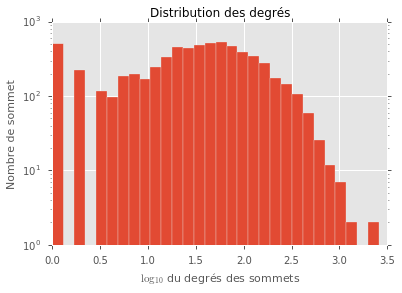

In [2]:
import pandas as pd
import lzma

A = pd.read_csv(lzma.open('net.adj.xz', 'rb'), sep='\t', index_col=0).iloc[:,:-1]
names = A.columns
A = np.abs(A.as_matrix()).astype(float)

degrees = A.sum(axis=1)
A /= degrees[:,None]



1 step
2 step
3 step
4 step
5 step
6 step


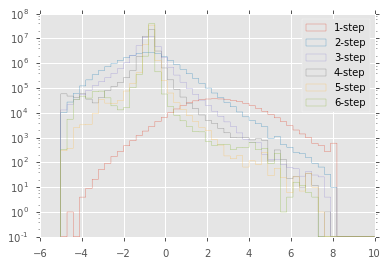

In [3]:
# parameters
lamb = 2 # Number of negative samples
K = 6 # Number of steps

# Constant, alg objects
N = A.shape[0]
beta = lamb / N
svd = TruncatedSVD(100)

# State
Ak = A.copy() # increasing powers of m
out = [] # SVD outputs for each steps

for k in range(1, K+1):
    print(k, 'step')
    SPPMI = np.log(Ak / (Ak.sum(0) * beta))
    plt.hist(SPPMI.flatten(), 50, range=(-5,10), histtype='step', label='%i-step' % k, log=True);
    
    #SPPMI = np.max(SPPMI, 0)
    SPPMI[SPPMI<0] = 0
    out.append(svd.fit_transform(SPPMI))
    
    if k < K:
        Ak = Ak.dot(A)
        
del Ak
del SPPMI
out = np.hstack(out)        
plt.legend();

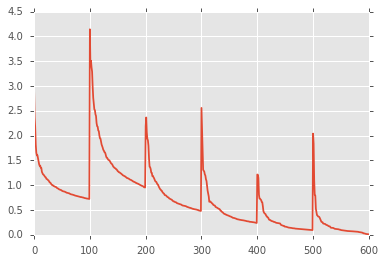

In [4]:
plt.plot(out.std(0))

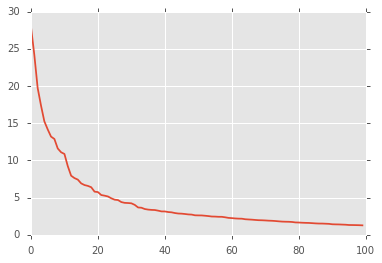

In [5]:
pca = PCA(100, whiten=False)
out_pca = pca.fit_transform(out)
out_norms = linalg.norm(out_pca, axis=1)
out_pca_norm = out_pca / out_norms[:,None]
plt.plot(pca.explained_variance_);

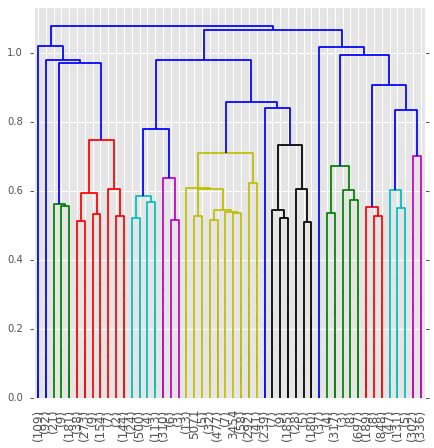

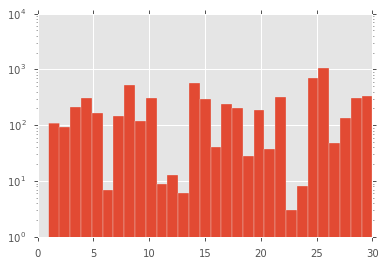

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster, leaves_list
from scipy.spatial.distance import pdist, squareform
nclust = 30
X = out_pca[:,:15]
Z = linkage(X, 'average', 'cosine')
#c, cds = cophenet(Z, pdist(X))
c = fcluster(Z, nclust, 'maxclust')

plt.figure(figsize=(7,7))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
);

plt.figure()
plt.hist(c, nclust, log=True);

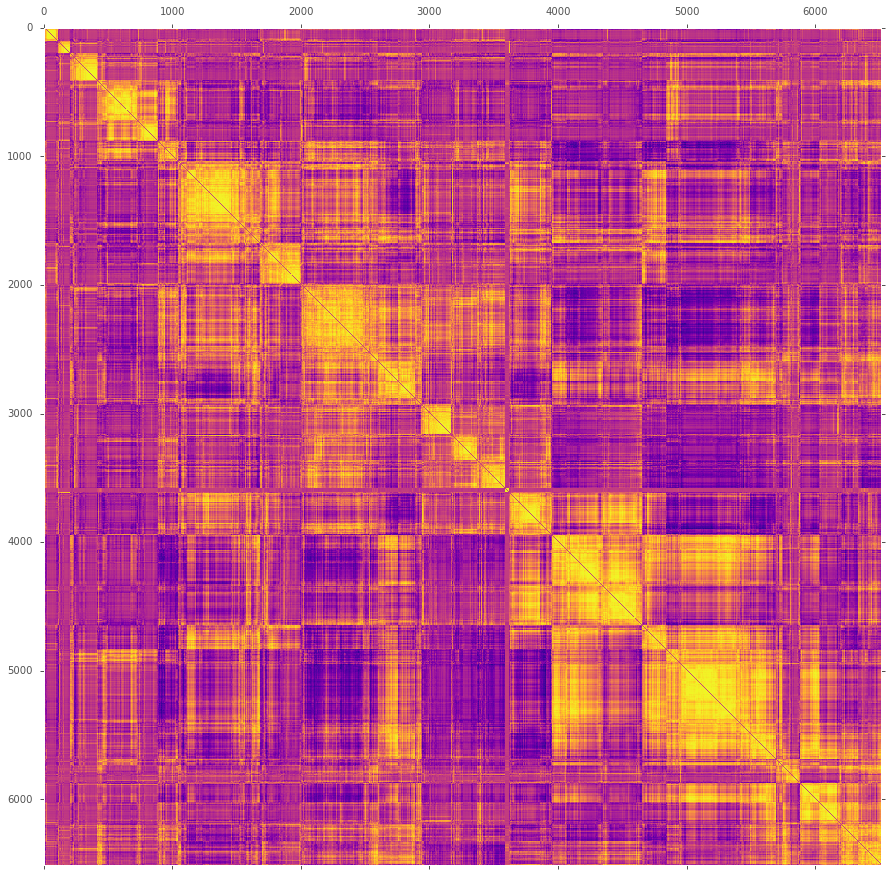

In [7]:
plt.figure(figsize=(15,15))
ax = plt.gca()
ax.matshow(squareform(1-pdist(out_pca[leaves_list(Z), :15], metric='cosine')), cmap=plt.cm.plasma);
ax.grid(False)

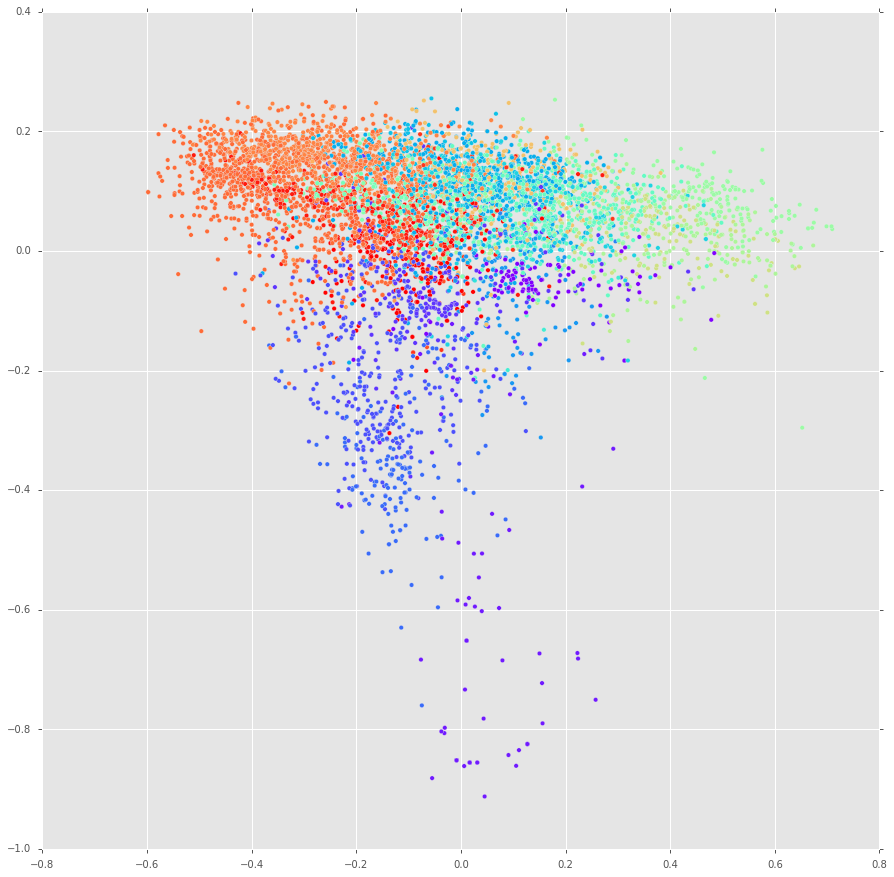

In [8]:
plt.figure(figsize=(15,15))
plt.scatter(out_pca_norm[:,0], out_pca_norm[:,1], c=c/c.max(), cmap=plt.cm.rainbow);

In [9]:
from sklearn.manifold.t_sne import TSNE
tsne = TSNE(verbose=1, learning_rate=1000.0, n_iter=10000, metric='l2')
out_tsne = tsne.fit_transform(out_pca_norm[:,:15])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6511
[t-SNE] Computed conditional probabilities for sample 2000 / 6511
[t-SNE] Computed conditional probabilities for sample 3000 / 6511
[t-SNE] Computed conditional probabilities for sample 4000 / 6511
[t-SNE] Computed conditional probabilities for sample 5000 / 6511
[t-SNE] Computed conditional probabilities for sample 6000 / 6511
[t-SNE] Computed conditional probabilities for sample 6511 / 6511
[t-SNE] Mean sigma: 0.167971
[t-SNE] Error after 100 iterations with early exaggeration: 1.531151
[t-SNE] Error after 275 iterations: 1.410246


In [10]:
links = np.vstack(np.where(np.triu(A, 1)>0)).T
simi_over_links = np.array([np.inner(out_pca_norm[i], out_pca_norm[j]) for (i,j) in links])

order = np.argsort(simi_over_links)
links = links[order]
simi_over_links = simi_over_links[order]
del order

In [11]:
from collections import defaultdict

mapto = defaultdict(set)
Ab = A > 0
for i,j in np.array(np.where(np.triu(np.inner(out_pca_norm, out_pca_norm),1) > 0.90)).T  :
    if Ab[i,j] or (Ab[i] & Ab[j]).any():
        continue
    ni = names[i]
    nj = names[j]
    mapto[ni].add(nj)
    mapto[nj].add(ni)
del Ab

for k, vs in sorted(mapto.items(), key=lambda item: len(item[1])):
    print("%s : %s" % (k, ' '.join(vs)))

856748 : 853212
853075 : 854743
853385 : 6396
855649 : 9164938
853578 : 854743
854432 : 834503
10063 : 90624
855745 : 2540389
854740 : 854743
853498 : 9164926
853625 : 850616
4751 : 852535
852060 : 9164938
853212 : 856748
854749 : 10291
853681 : 10291
852966 : 10291
851741 : 2540389
851460 : 10291
856197 : 10291
9164985 : 9164938
57634 : 5524
853197 : 856462
855767 : 855430
852069 : 155908
5566 : 131118
7290 : 5524
851201 : 2540389
850552 : 269966
851471 : 10291
855332 : 23524
852748 : 854743
850859 : 851687
850808 : 10291
68051 : 6396
10987 : 8454
26754 : 8454
856462 : 853197
854881 : 10963
850820 : 9164938
851937 : 854743
641 : 821455
852535 : 4751
853565 : 854743
855410 : 854743
851470 : 6396
853030 : 2540389
9276 : 51693
4863 : 5524
851755 : 854743
855952 : 2540389
5423 : 472
10847 : 5524
854960 : 10291
852007 : 10963
850703 : 23524
856233 : 10403
375 : 51693
851948 : 854743
853701 : 854743
852788 : 269966
22820 : 51693
854715 : 854743
9164934 : 116549
852084 : 10291
852889 : 25403

In [40]:
import goenrich
import sqlite3
O = goenrich.obo.ontology('go-basic.obo')
gene2go = pd.read_sql('SELECT go_id, gene_id FROM genes, go_bp WHERE genes._id = go_bp._id',
                      sqlite3.connect('org.Sc.sgd.sqlite'))
goenrich.enrich.propagate(O, {k:set(v) for k,v in gene2go.groupby('go_id')['gene_id']}, 'background')

In [51]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=30, verbose=0)
km.fit(out_pca[:,:15])
kmc = km.labels_

In [65]:
genes = names[kmc==26]
print(len(genes))
print(' '.join(genes))

df = goenrich.enrich.analyze(O, genes, 'background', gvfile='test.dot').dropna().sort_values('q').head(20)
!dot test.dot -Tpdf -o test.pdf
df 

266
7917 851896 856883 850794 51693 856477 375 22820 9276 850805 854336 855196 854914 852872 851677 853963 850952 855029 855764 852670 850398 851931 852196 850519 855337 852106 852303 854514 856501 854767 850456 850376 854840 852647 856008 855928 850745 855242 850904 855240 851459 855945 852044 851181 854949 851462 850941 855874 854149 853866 855278 853608 854763 851857 850513 855760 851372 852324 855678 855683 852097 853863 851627 853082 851095 850713 855221 856821 854270 851979 854373 850782 854813 851151 854697 852649 855306 854995 850943 856398 850767 854201 855830 855458 856740 851314 855103 853261 856478 853589 853017 850431 855785 854233 850800 856587 853384 853265 853825 852530 853142 851241 854252 852625 851210 854163 850411 854718 855317 855076 853889 853497 853319 853393 852796 850354 852172 854276 855153 855022 854772 852826 856668 851918 853453 856354 854300 854236 855676 855687 852879 856669 852857 855842 853916 851997 854391 853581 853256 853582 855394 852660 856040 8545

/home/piezo/.local/lib/python3.5/site-packages/goenrich/enrich.py:38: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  sig = df.sort('q').head(top)['term']


,M,N,n,name,namespace,p,q,rejected,term,x
6008,6336,266,4,fungal-type cell wall beta-glucan biosynthetic...,biological_process,0.000000e+00,0.000000e+00,1.0,GO:0070880,4
29518,6336,266,4,fungal-type cell wall beta-glucan metabolic pr...,biological_process,0.000000e+00,0.000000e+00,1.0,GO:0070879,4
1224,6336,266,4,protein N-linked glycosylation via asparagine,biological_process,0.000000e+00,0.000000e+00,1.0,GO:0018279,4
6329,6336,266,4,cell wall beta-glucan metabolic process,biological_process,0.000000e+00,0.000000e+00,1.0,GO:0034406,4
21404,6336,266,368,vesicle-mediated transport,biological_process,1.181591e-91,3.958330e-89,1.0,GO:0016192,126
810,6336,266,187,Golgi vesicle transport,biological_process,1.232002e-85,3.439339e-83,1.0,GO:0048193,94
13075,6336,266,402,intracellular protein transport,biological_process,3.521441e-46,8.426306e-44,1.0,GO:0006886,91
24374,6336,266,76,vesicle organization,biological_process,7.529327e-39,1.576453e-36,1.0,GO:0016050,41
20842,6336,266,295,single-organism membrane organization,biological_process,1.687520e-34,3.140662e-32,1.0,GO:0044802,68
29666,6336,266,299,membrane organization,biological_process,4.256202e-34,7.129139e-32,1.0,GO:0061024,68


In [ ]:
plt.hist([np.inner(out_pca_norm[i], out_pca_norm[j]) for (i,j) in np.vstack(np.where(np.triu(A>0, 1))).T], 100, log=True);

In [ ]:
plt.hist([np.inner(out_pca_norm[i], out_pca_norm[j]) for (i,j) in np.vstack(np.where(np.triu(A==0, 1))).T], 100, log=True);

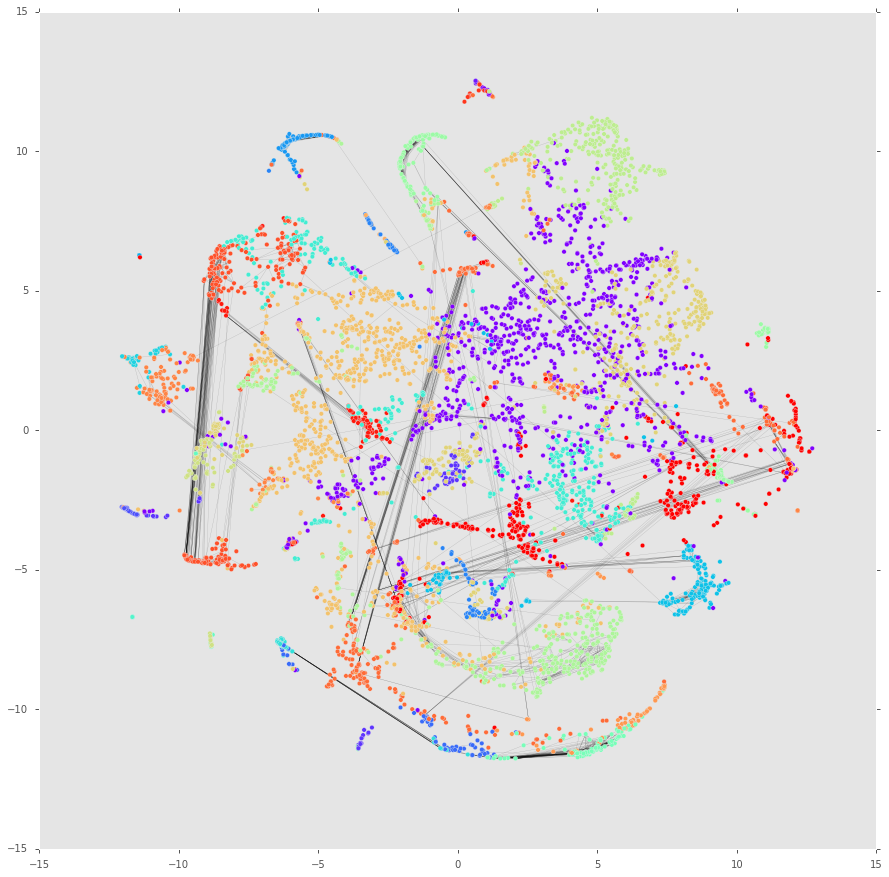

In [54]:
from matplotlib import collections  as mc
X = out_tsne
plt.figure(figsize=(15,15))

lines = [((X[i,0], X[i,1]), (X[j,0], X[j,1])) for (i,j) in links[::-1][:5000]]
plt.gca().add_collection(mc.LineCollection(lines, linewidths=0.25, colors=(0,0,0,0.25), zorder=0))
del lines

plt.scatter(X[:,0], X[:,1], c=kmc/kmc.max(), cmap=plt.cm.rainbow);
plt.gca().grid(False)